In [12]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Şarap kalitesini belirleyen kimyasal özellikleri kullanarak sınıflandırma yapacağız.

In [13]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Veri yükleme
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
wine_data = pd.read_csv(url, sep=';')

# İkili sınıflandırma için kalite skorunu dönüştür
wine_data['quality_binary'] = (wine_data['quality'] >= 6).astype(int)

# Özellikler ve hedef değişken
X = wine_data.drop(['quality', 'quality_binary'], axis=1)
y = wine_data['quality_binary']

### Veri Ön İşleme

In [14]:
# Veriyi böl
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Özellik ölçeklendirme (SVM için kritik!)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Farklı Kernel'lar ile Deneme

In [15]:
# Kernel türleri
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
results = {}

for kernel in kernels:
    print(f"\n{kernel.upper()} Kernel ile eğitim...")
    
    # Model oluştur
    svm_model = SVC(kernel=kernel, random_state=42)
    
    # Eğit
    svm_model.fit(X_train_scaled, y_train)
    
    # Tahmin et
    y_pred = svm_model.predict(X_test_scaled)
    
    # Sonuçları kaydet
    from sklearn.metrics import accuracy_score
    accuracy = accuracy_score(y_test, y_pred)
    results[kernel] = accuracy
    
    print(f"Accuracy: {accuracy:.4f}")


LINEAR Kernel ile eğitim...
Accuracy: 0.7354

POLY Kernel ile eğitim...
Accuracy: 0.7396

RBF Kernel ile eğitim...
Accuracy: 0.7458

SIGMOID Kernel ile eğitim...
Accuracy: 0.6646


### Hiperparametre Optimizasyonu

In [16]:
from sklearn.model_selection import GridSearchCV

# RBF kernel için parametre arama
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    'kernel': ['rbf']
}

# Grid search
grid_search = GridSearchCV(
    SVC(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)

print("En iyi parametreler:", grid_search.best_params_)
print("En iyi CV skoru:", grid_search.best_score_)

En iyi parametreler: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
En iyi CV skoru: 0.7623038116591927


## SVM Hiperparametreleri Derinlemesine
### C Parametresi: Ceza Faktörü
### C parametresi, marjin genişliği ile sınıflandırma hatası arasındaki dengeyi kontrol eder:

### Düşük C (C ≈ 0.1): Geniş marjin, daha fazla hata toleransı
### Yüksek C (C ≈ 100): Dar marjin, az hata toleransı

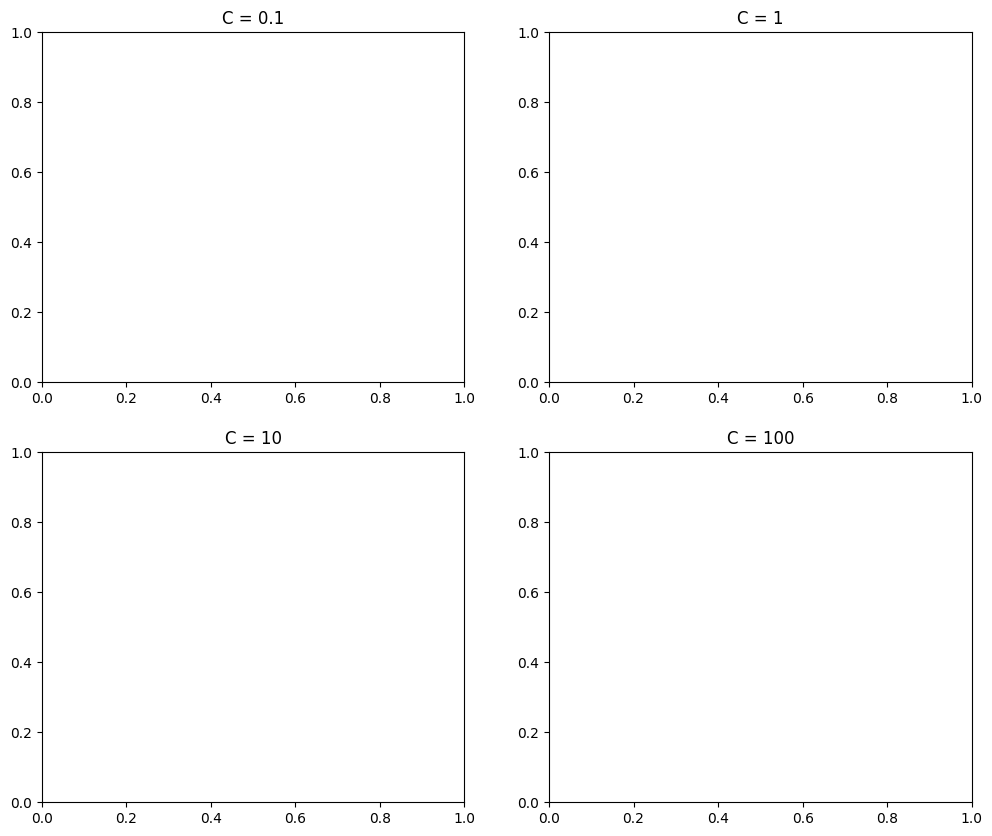

In [17]:
# C parametresinin etkisini görselleştir
C_values = [0.1, 1, 10, 100]
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for i, C in enumerate(C_values):
    ax = axes[i//2, i%2]
    
    svm = SVC(kernel='rbf', C=C)
    svm.fit(X_train_scaled[:, :2], y_train)  # Sadece 2 özellik görselleştirme için
    
    # Karar sınırını çiz
    # ... görselleştirme kodu ...
    
    ax.set_title(f'C = {C}')

## Gamma Parametresi (RBF Kernel için)
### Gamma, RBF kernel'in "etkisini" kontrol eder:

### Düşük Gamma: Geniş etki, düzgün karar sınırı
### Yüksek Gamma: Dar etki, karmaşık karar sınırı

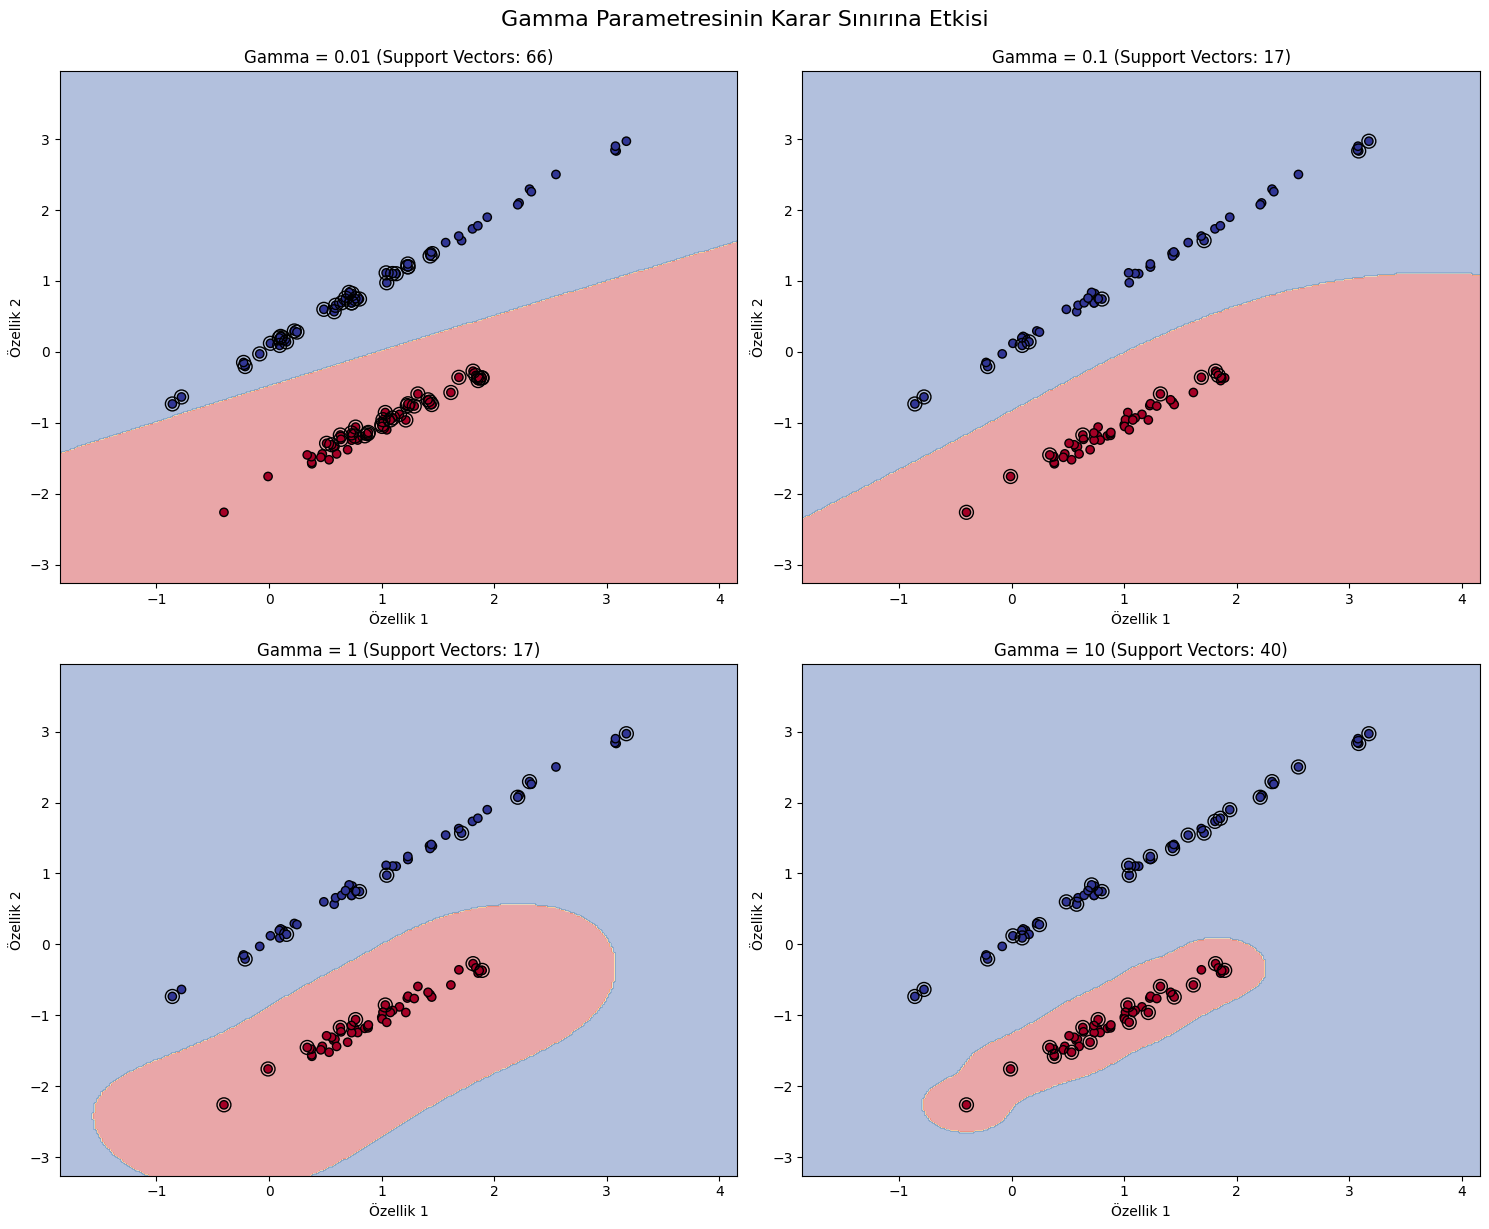

In [18]:
# Gamma parametresinin etkisini görselleştir
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
import numpy as np

# Basit 2D dataset oluştur (görselleştirme için)
X_simple, y_simple = make_classification(
    n_samples=100, n_features=2, n_redundant=0, 
    n_informative=2, random_state=42, n_clusters_per_class=1
)

gamma_values = [0.01, 0.1, 1, 10]
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

for i, gamma in enumerate(gamma_values):
    ax = axes[i//2, i%2]
    
    # SVM modeli oluştur
    svm = SVC(kernel='rbf', C=1, gamma=gamma)
    svm.fit(X_simple, y_simple)
    
    # Meshgrid oluştur
    h = 0.02
    x_min, x_max = X_simple[:, 0].min() - 1, X_simple[:, 0].max() + 1
    y_min, y_max = X_simple[:, 1].min() - 1, X_simple[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Tahminleri al
    mesh_points = np.c_[xx.ravel(), yy.ravel()]
    Z = svm.predict(mesh_points)
    Z = Z.reshape(xx.shape)
    
    # Karar sınırını çiz
    ax.contourf(xx, yy, Z, alpha=0.4, cmap='RdYlBu')
    
    # Veri noktalarını çiz
    scatter = ax.scatter(X_simple[:, 0], X_simple[:, 1], 
                        c=y_simple, cmap='RdYlBu', edgecolors='black')
    
    # Support vector'leri vurgula
    ax.scatter(X_simple[svm.support_, 0], X_simple[svm.support_, 1], 
              s=100, linewidth=1, facecolors='none', edgecolors='black')
    
    ax.set_title(f'Gamma = {gamma} (Support Vectors: {len(svm.support_)})')
    ax.set_xlabel('Özellik 1')
    ax.set_ylabel('Özellik 2')

plt.tight_layout()
plt.suptitle('Gamma Parametresinin Karar Sınırına Etkisi', y=1.02, size=16)
plt.show()

### Çıktıyı analiz edelim:

#### Gamma = 0.01: Çok geniş, düzgün karar sınırı (underfitting riski)
#### Gamma = 0.1: Dengeli, makul karar sınırı
#### Gamma = 1: Daha karmaşık, detaylı sınır
#### Gamma = 10: Aşırı karmaşık, overfitting riski

## C ve Gamma'nın Birlikte Etkisi

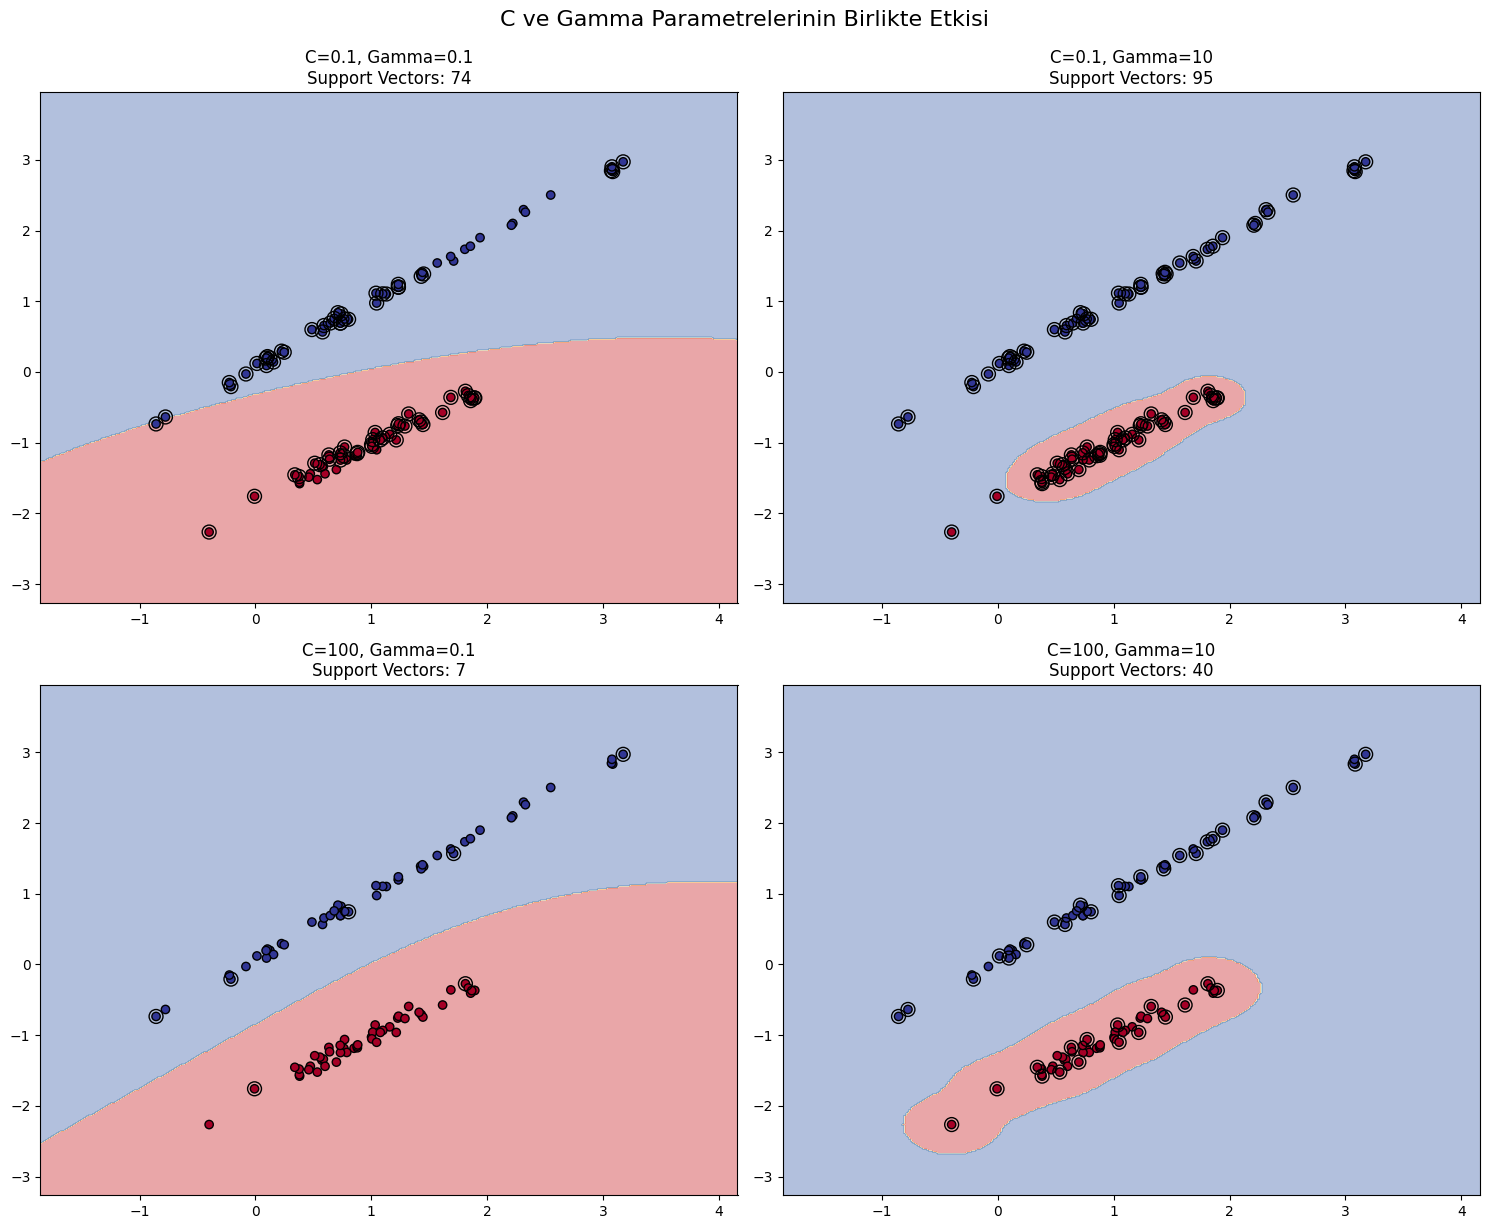

In [19]:
# C ve Gamma'nın kombinasyon etkisi
C_gamma_combinations = [
    (0.1, 0.1),   # Düşük C, Düşük Gamma
    (0.1, 10),    # Düşük C, Yüksek Gamma  
    (100, 0.1),   # Yüksek C, Düşük Gamma
    (100, 10)     # Yüksek C, Yüksek Gamma
]

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

for i, (C, gamma) in enumerate(C_gamma_combinations):
    ax = axes[i//2, i%2]
    
    svm = SVC(kernel='rbf', C=C, gamma=gamma)
    svm.fit(X_simple, y_simple)
    
    # Karar sınırını çiz (önceki kod ile aynı)
    h = 0.02
    x_min, x_max = X_simple[:, 0].min() - 1, X_simple[:, 0].max() + 1
    y_min, y_max = X_simple[:, 1].min() - 1, X_simple[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    ax.contourf(xx, yy, Z, alpha=0.4, cmap='RdYlBu')
    ax.scatter(X_simple[:, 0], X_simple[:, 1], 
              c=y_simple, cmap='RdYlBu', edgecolors='black')
    ax.scatter(X_simple[svm.support_, 0], X_simple[svm.support_, 1], 
              s=100, linewidth=1, facecolors='none', edgecolors='black')
    
    ax.set_title(f'C={C}, Gamma={gamma}\nSupport Vectors: {len(svm.support_)}')

plt.tight_layout()
plt.suptitle('C ve Gamma Parametrelerinin Birlikte Etkisi', y=1.02, size=16)
plt.show()

## Model Değerlendirmesi ve Yorumlama
### Confusion Matrix Analizi

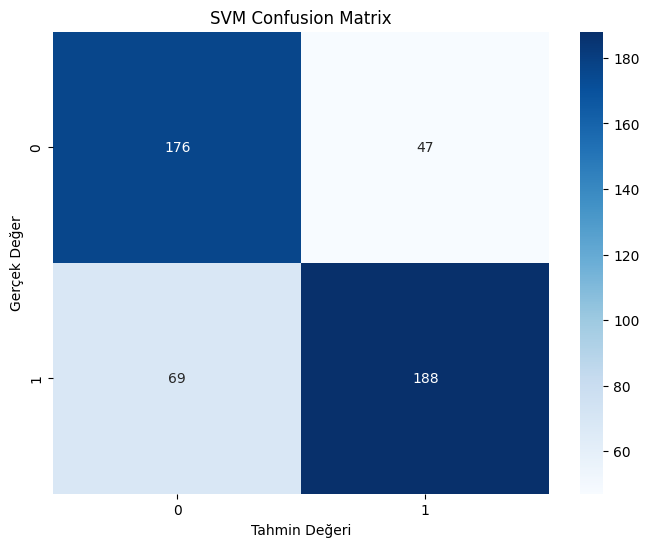


Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.79      0.75       223
           1       0.80      0.73      0.76       257

    accuracy                           0.76       480
   macro avg       0.76      0.76      0.76       480
weighted avg       0.76      0.76      0.76       480



In [20]:
# En iyi modeli kullan
best_svm = grid_search.best_estimator_
y_pred = best_svm.predict(X_test_scaled)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('SVM Confusion Matrix')
plt.ylabel('Gerçek Değer')
plt.xlabel('Tahmin Değeri')
plt.show()

# Detaylı rapor
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

### Support Vector Analizi

In [21]:
# Support vector sayısı
print(f"Support Vector Sayısı: {len(best_svm.support_)}")
print(f"Toplam Veri Sayısı: {len(X_train_scaled)}")
print(f"Support Vector Oranı: {len(best_svm.support_)/len(X_train_scaled):.2%}")

Support Vector Sayısı: 633
Toplam Veri Sayısı: 1119
Support Vector Oranı: 56.57%


## SVM vs Diğer Algoritmalar

### Karşılaştırmalı Analiz

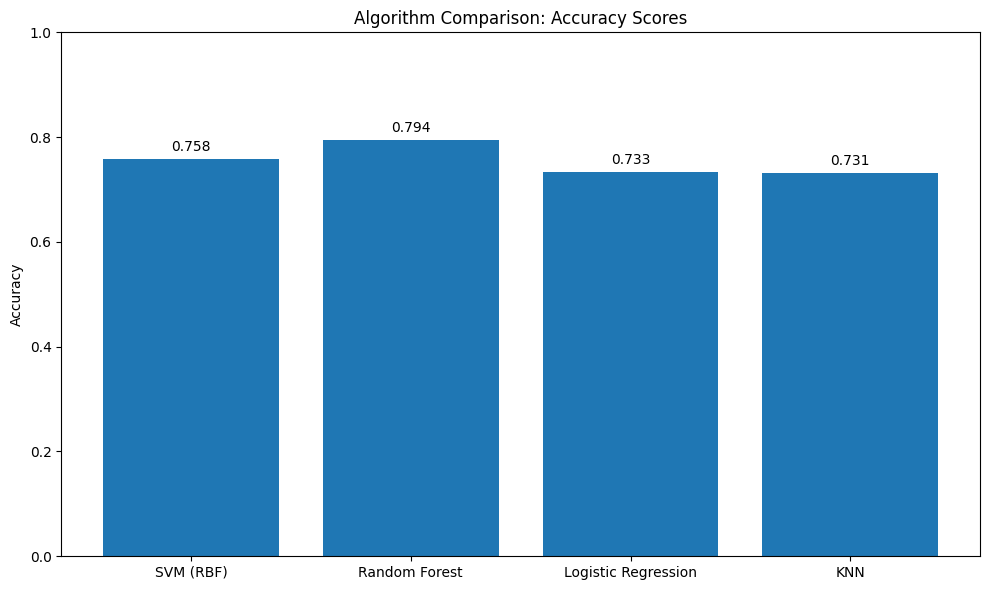

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Farklı algoritmalar
algorithms = {
    'SVM (RBF)': SVC(kernel='rbf', C=10, gamma=0.1),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'Logistic Regression': LogisticRegression(),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

comparison_results = {}

for name, algo in algorithms.items():
    algo.fit(X_train_scaled, y_train)
    accuracy = algo.score(X_test_scaled, y_test)
    comparison_results[name] = accuracy

# Sonuçları görselleştir
plt.figure(figsize=(10, 6))
algorithms_names = list(comparison_results.keys())
accuracies = list(comparison_results.values())

bars = plt.bar(algorithms_names, accuracies)
plt.title('Algorithm Comparison: Accuracy Scores')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

# Değerleri çubukların üzerine yaz
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{acc:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()